In [383]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [438]:
# Useful Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# Other Source Files
import dlqr, grnn, utils, controller

In [439]:
%matplotlib inline
np.set_printoptions(precision=3)

In [440]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Create Environment

In [441]:
N = 20
T = 50
degree = 5 + 1     # All nodes have self-loops

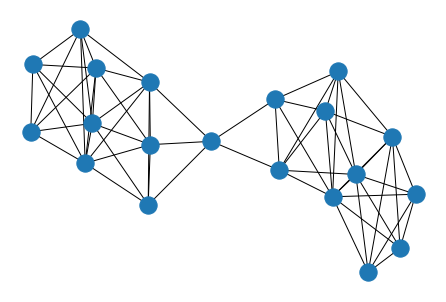

In [468]:
# Generate environment
G, S, A, B, Q, R = dlqr.generate_lq_env(N, degree, device)
P, K, X = dlqr.lqr_solve(A, B, Q, R)
# Draw the topology
nx.draw_kamada_kawai(G)

## Train GRNN

In [469]:
# Define training loss
def criterion(x_traj, u_traj, Q, R, QT):
  # The x and u trajectories are (50,20,1)
  return dlqr.LQ_cost(x_traj[:,:,0], u_traj[:,:,0], Q, R, QT)

In [470]:
# Create model
model = grnn.GRNN(S, N, T, p=1, q=1, h=5, S_trainable=True).to(device)

In [471]:
# Train model
model = utils.train_model(model, criterion, S, N, T, A, B, Q, R, Q, beta=0, num_epoch=100, verbose=True)

Epoch: 1 	 Loss: 5087.428129184535
Epoch: 11 	 Loss: 42.35698395736988
Epoch: 21 	 Loss: 38.4789351832503
Epoch: 31 	 Loss: 31.9288833850313
Epoch: 41 	 Loss: 34.78925996786096
Epoch: 51 	 Loss: 30.113229887686295
Epoch: 61 	 Loss: 29.19348370946169
Epoch: 71 	 Loss: 29.017809316538823
Epoch: 81 	 Loss: 26.81501074794632
Epoch: 91 	 Loss: 26.584211292725968


## Visualize a single Trajectory

In [483]:
def lqr_sim_func(x0, controller, device):
    return dlqr.sim_forward(x0, controller, A, B, T, device)
def lqr_cost_func(x, u):
    return dlqr.LQ_cost(x, u, Q, R, P)

In [490]:
# Define controllers we want to compare
lqrctrl = dlqr.LQRSSController(A, B, Q, R, T)
grnnctrl = model.get_controller()
# TODO: define p, q; this is part of the effort to standardize the representation of states
zeroctrl = controller.ZeroController(20)
randctrl = controller.RandomController(20)
controllers = [lqrctrl.control, grnnctrl.control, zeroctrl.control, randctrl.control]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']

# Generate a single episode of trajectories for each controller
x0 = torch.randn(20)
xs, us, costs = utils.sim_controllers(lqr_sim_func, lqr_cost_func, x0, controllers, device)

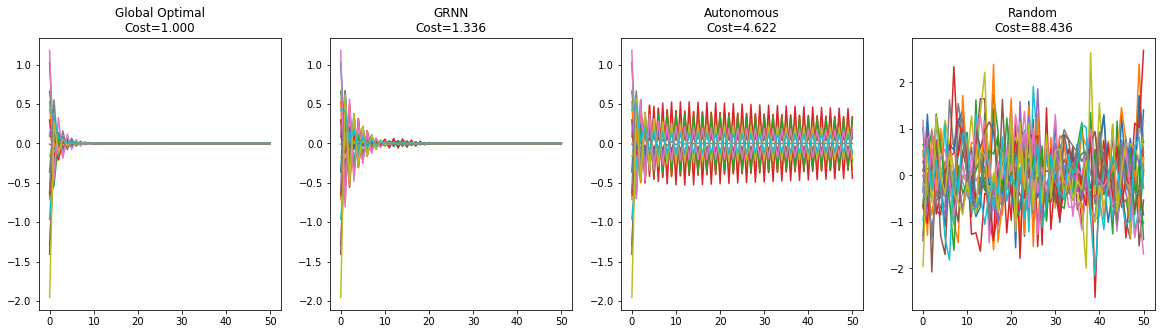

In [491]:
utils.plot_controllers(xs, names, costs, 0)

## Testing how well GRNN works on LQR systems

In [381]:
num_topologies = 1
num_x0s = 2
num_controllers = 4

total_rel_costs = np.zeros(num_controllers)
relative_ind = 0

for _ in range(num_topologies):
    G, S, A, B, Q, R = dlqr.generate_lq_env(N, degree, device)
    model = grnn.GRNN(S, N, T, p=1, q=1, h=5).to(device)
    model = utils.train_model(model, criterion, S, N, T, A, B, Q, R, beta=0, num_epoch=30, verbose=True)
    grnnctrl = model.get_controller()
    lqrctrl = dlqr.LQRSSController(A, B, Q, R, T)
    controllers = [lqrctrl.control, grnnctrl.control, zeroctrl.control, randctrl.control]
    for _ in range(num_x0s):
        x0 = torch.randn(20)
        _, _, costs = utils.sim_controllers(lqr_sim_func, lqr_cost_func, x0, controllers, device)
        print(utils.relative_costs(costs, relative_ind))
        total_rel_costs = total_rel_costs + utils.relative_costs(costs, relative_ind)

[ 1.     7.615  1.81  59.922]
[ 1.     7.066  1.27  87.085]


In [ ]:
myS = torch.tensor(torch.abs(model.S)>0.001,dtype=torch.uint8).detach().cpu().numpy()
G = nx.Graph(myS)
nx.draw_kamada_kawai(G)
torch.sum(torch.tensor(((torch.abs(model.S)>.001)),dtype=torch.uint8))